In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

1. 데이터 확인하기

In [2]:
data_dir = '../input/chinese-mnist/data/data' # jpg 형식의 data 불러오기

In [3]:
mnist=pd.read_csv('../input/chinese-mnist/chinese_mnist.csv')
mnist

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九
...,...,...,...,...,...
14995,99,5,9,8,八
14996,99,6,9,8,八
14997,99,7,9,8,八
14998,99,8,9,8,八


In [4]:
Name=sorted(mnist['value'].unique()) # 어떤 value들이 존재하는지 check
Name

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000, 10000, 100000000]

2. 자료 가공하기

In [5]:
n=len(Name)
print(n)

# Name에 들어있는 값들에 대해 value mapping 해주기
N=[]
for i in range(n):
    N+=[i]
    
normal_mapping=dict(zip(Name,N )) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]

print(normal_mapping)

15
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 100: 11, 1000: 12, 10000: 13, 100000000: 14}


In [6]:
datax0=[]
dataf0=[]
# tqdm은 상태 진행율을 보여줌. jpg 형식의 파일을 'img_to_array'로 array로 만들어주기
for im in tqdm(os.listdir(data_dir)):
    image=load_img(os.path.join(data_dir,im), grayscale=False, color_mode='rgb', target_size=(64,64))
    image=img_to_array(image)
    image=image/255.0 # 정규화
    datax0+=[image] # 64 x 64 형태의 array
    dataf0+=[im] # 파일의 이름

100%|██████████| 15000/15000 [01:08<00:00, 219.33it/s]


In [7]:
dataf1=[]
for item in dataf0:
    dataf1+=[int(item[0:-4].split('_')[3])-1] # 파일의 이름을 split 해서 'label' 파일 생성

In [8]:
m=len(datax0)
M=[]
for i in range(m):
    M+=[i]
random.shuffle(M) # image file의 index random shuffle 해주기
m

15000

In [9]:
datax2=np.array(datax0)
dataf2=np.array(dataf1)

# 3:1 비율로 train과 test set 나눠주기
trainx0=datax2[M[0:(m//4)*3]] # // 연산자 -> 몫 찾아주는 연산자
testx0=datax2[M[(m//4)*3:]]
trainy0=dataf2[M[0:(m//4)*3]]
testy0=dataf2[M[(m//4)*3:]]

In [10]:
trainy1=to_categorical(trainy0) # one-hot encoding
#testy1=to_categorical(testy0)

In [11]:
Trainx1=np.array(trainx0)
Trainy1=np.array(trainy1)
Testx1=np.array(testx0)
#Testy1=np.array(testy1)

In [12]:
trainx,testx,trainy,testy=train_test_split(Trainx1,Trainy1,test_size=0.2,random_state=44)

In [13]:
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(9000, 64, 64, 3)
(2250, 64, 64, 3)
(9000, 15)
(2250, 15)


In [14]:
# data augmentation function
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

3. Model1 - DenseNet201

In [15]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(64,64,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

74842112/74836368 [==============================] - 0s 0us/step


In [16]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(15, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=40)

Epoch 1/40
282/282 [==============================] - 131s 430ms/step - loss: 1.5697 - accuracy: 0.4793 - val_loss: 0.6286 - val_accuracy: 0.7769
Epoch 2/40
282/282 [==============================] - 117s 415ms/step - loss: 0.6342 - accuracy: 0.7749 - val_loss: 0.4821 - val_accuracy: 0.8351
Epoch 3/40
282/282 [==============================] - 117s 414ms/step - loss: 0.5026 - accuracy: 0.8236 - val_loss: 0.4151 - val_accuracy: 0.8524
Epoch 4/40
282/282 [==============================] - 118s 417ms/step - loss: 0.4586 - accuracy: 0.8370 - val_loss: 0.3446 - val_accuracy: 0.8818
Epoch 5/40
282/282 [==============================] - 118s 417ms/step - loss: 0.4185 - accuracy: 0.8518 - val_loss: 0.3224 - val_accuracy: 0.8938
Epoch 6/40
282/282 [==============================] - 118s 417ms/step - loss: 0.3934 - accuracy: 0.8565 - val_loss: 0.3123 - val_accuracy: 0.8844
Epoch 7/40
282/282 [==============================] - 117s 417ms/step - loss: 0.3695 - accuracy: 0.8693 - val_loss: 0.3009 -

In [19]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       147
           1       1.00      0.91      0.95       165
           2       0.85      0.96      0.90       138
           3       0.95      0.94      0.94       162
           4       1.00      0.88      0.93       154
           5       0.94      0.94      0.94       139
           6       0.91      0.96      0.94       133
           7       0.91      0.91      0.91       152
           8       0.99      1.00      1.00       147
           9       0.93      0.90      0.92       157
          10       0.98      0.95      0.96       150
          11       0.90      0.91      0.90       138
          12       0.95      0.93      0.94       169
          13       0.87      0.90      0.88       163
          14       0.84      0.96      0.90       136

    accuracy                           0.93      2250
   macro avg       0.94      0.94      0.93      2250
weighted avg       0.94   

평가1: 50 x 50에서 64 x 64로 크기를 키웠더니 0.80에서 0.9467까지 상승

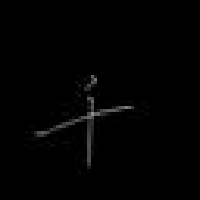

In [20]:
img0='../input/chinese-mnist/data/data/input_100_1_13.jpg'
load_img(img0,target_size=(200,200))

In [21]:
image=load_img(img0,target_size=(64,64))
image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image=np.expand_dims(image, axis=0)

In [22]:
prediction=model.predict(prediction_image)
value=np.argmax(prediction)
pred_name=mapper(value)
name0=img0[0:-4].split('_')[3]
name=mapper(int(name0)-1)
print("Prediction is {}.".format(pred_name))
print("Answer is {}.".format(name))

Prediction is 1000.
Answer is 1000.


3. Model2 - CNN

In [23]:
from keras.models import Sequential

In [24]:
model = Sequential()
model.add(tf.keras.layers.Conv2D(128, 3,
                                 padding = "same", 
                                 activation = "relu", 
                                 input_shape=[64, 64, 3]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = 2))

model.add(tf.keras.layers.Conv2D(128, 3,
                                 padding = "same", 
                                 activation = "relu", 
                                 input_shape=[64, 64, 3]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = 2))
model.add(tf.keras.layers.Flatten())

# model.add(tf.keras.layers.Dropout())
model.add(tf.keras.layers.Dense(128,activation = "relu"))
model.add(tf.keras.layers.Dense(trainy.shape[1],activation = "softmax"))
model.compile(optimizer='adam',
              loss = "categorical_crossentropy", 
              metrics = ['accuracy'])  

In [25]:
history = model.fit(trainx,trainy,validation_data=(testx,testy),epochs=20)

Epoch 1/20
282/282 [==============================] - 134s 473ms/step - loss: 1.4151 - accuracy: 0.5643 - val_loss: 0.2674 - val_accuracy: 0.9178
Epoch 2/20
282/282 [==============================] - 135s 478ms/step - loss: 0.2008 - accuracy: 0.9321 - val_loss: 0.2230 - val_accuracy: 0.9271
Epoch 3/20
282/282 [==============================] - 133s 471ms/step - loss: 0.1018 - accuracy: 0.9689 - val_loss: 0.1494 - val_accuracy: 0.9609
Epoch 4/20
282/282 [==============================] - 136s 482ms/step - loss: 0.0425 - accuracy: 0.9876 - val_loss: 0.1958 - val_accuracy: 0.9502
Epoch 5/20
282/282 [==============================] - 134s 475ms/step - loss: 0.0292 - accuracy: 0.9909 - val_loss: 0.2002 - val_accuracy: 0.9507
Epoch 6/20
282/282 [==============================] - 134s 474ms/step - loss: 0.0242 - accuracy: 0.9924 - val_loss: 0.1865 - val_accuracy: 0.9560
Epoch 7/20
282/282 [==============================] - 132s 469ms/step - loss: 0.0295 - accuracy: 0.9924 - val_loss: 0.2164 -

In [26]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       147
           1       0.99      1.00      1.00       165
           2       0.95      0.97      0.96       138
           3       0.98      0.96      0.97       162
           4       0.98      0.98      0.98       154
           5       0.96      0.99      0.98       139
           6       0.98      0.98      0.98       133
           7       0.99      0.95      0.97       152
           8       0.99      0.99      0.99       147
           9       0.96      0.97      0.96       157
          10       0.97      0.97      0.97       150
          11       0.98      0.94      0.96       138
          12       0.99      0.96      0.97       169
          13       0.96      0.96      0.96       163
          14       0.96      0.98      0.97       136

    accuracy                           0.97      2250
   macro avg       0.97      0.97      0.97      2250
weighted avg       0.97   